# Assignment 2 For Clustering: Sessa Empirical Estimator


*   Ouano, Luis Andrei E.
*   Detablan, Paul France M.


## Instructions
Assignment 2 For Clustering: Sessa Empirical Estimator


1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Sunday, Feb 23, 2022 at 11:59 pm
7. Do this with your thesis partner.
8. You can use any A.I. assistant.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Load data
med_events = pd.read_csv("med_events.csv")

# Rename columns to match the R code naming convention
tidy = med_events.copy()
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

# Convert date to datetime format
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

In [10]:
def see_kmeans(arg1):
    """
    Sessa Empirical Estimator using K-means clustering

    Parameters:
    arg1 (str): Medication category (e.g., "medA")

    Returns:
    pandas.DataFrame: Processed dataframe with clustering results
    """
    # Filter for the given medication category
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()

    # Initialize variables similar to R code
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()

    # Sort by patient ID and date, and calculate previous date
    Drug_see_p1 = Drug_see_p1.sort_values(['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)

    # Filter out rows without previous dates
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])

    # Sample one row per patient (similar to R's ddply functionality)
    Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)

    # Keep only needed columns and calculate event intervals
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days

    # Generate empirical cumulative distribution
    x = np.sort(Drug_see_p1['event.interval'].values)
    y = np.arange(1, len(x)+1) / len(x)

    # Create a dataframe for ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})

    # Retain the 80% of ECDF (equivalent to R's dfper[which(dfper$y<=0.8),])
    dfper = dfper[dfper['y'] <= 0.8].copy()

    # Plot ECDF for visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(dfper['x'], dfper['y'])
    axes[0].set_title("80% ECDF")
    axes[1].plot(x, y)
    axes[1].set_title("100% ECDF")
    plt.tight_layout()
    plt.show()

    # Get maximum x value in filtered ECDF
    ni = dfper['x'].max()

    # Filter event intervals by the maximum value
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event.interval'] <= ni].copy()

    # Create density plot of log-transformed intervals
    plt.figure(figsize=(8, 5))
    sns.kdeplot(np.log(Drug_see_p2['event.interval'].astype(float)), shade=True)
    plt.title("Log(event interval)")
    plt.show()

    # Prepare data for clustering (equivalent to R's scale function)
    event_intervals = dfper['x'].values.reshape(-1, 1)
    scaler = StandardScaler()
    scaled_intervals = scaler.fit_transform(event_intervals)

    # Find optimal number of clusters using silhouette score
    silhouette_scores = []
    range_n_clusters = range(2, min(10, len(scaled_intervals)))

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        cluster_labels = kmeans.fit_predict(scaled_intervals)
        silhouette_avg = silhouette_score(scaled_intervals, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plot silhouette scores
    plt.figure(figsize=(8, 5))
    plt.plot(range_n_clusters, silhouette_scores, 'o-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Analysis for KMeans")
    plt.grid(True)
    plt.show()

    # Get optimal number of clusters
    max_cluster = range_n_clusters[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters for K-means: {max_cluster}")

    # Perform K-means clustering with optimal number of clusters
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = kmeans.fit_predict(event_intervals)

    # Calculate statistics for each cluster (min, max, median)
    cluster_stats = dfper.groupby('cluster').agg({
        'x': ['min', 'max', 'median']
    })
    cluster_stats.columns = ['Minimum', 'Maximum', 'Median']
    cluster_stats = cluster_stats.reset_index()

    # Process cluster medians and handle infinite values
    nif = cluster_stats.copy()

    # Create results dataframe
    results = pd.DataFrame()
    for index, row in nif.iterrows():
        cluster_results = Drug_see_p1[
            (Drug_see_p1['event.interval'] >= row['Minimum']) &
            (Drug_see_p1['event.interval'] <= row['Maximum'])
        ].copy()
        cluster_results['Cluster'] = row['cluster']
        cluster_results['Median'] = row['Median']
        results = pd.concat([results, cluster_results])

    # Handle cases where intervals didn't fall into any cluster
    results = results.dropna(subset=['Cluster'])
    results = results[['pnr', 'Median', 'Cluster']]

    # Get most common cluster
    t1 = pd.DataFrame({'Cluster': [results['Cluster'].value_counts().idxmax()]})
    t1_median = results[results['Cluster'] == t1['Cluster'].iloc[0]]['Median'].iloc[0]
    t1['Median'] = t1_median

    # Merge results back to original data
    Drug_see_p1 = pd.merge(Drug_see_p1, results[['pnr', 'Median', 'Cluster']],
                            on='pnr', how='left')

    # Fill NAs with the most common cluster's median
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(t1['Median'].iloc[0])
    Drug_see_p1['Cluster'] = Drug_see_p1['Cluster'].fillna("0")
    Drug_see_p1['test'] = round(Drug_see_p1['event.interval'] - Drug_see_p1['Median'], 1)

    # Extract columns for merging
    Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'Cluster']]

    # Assign duration
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p3, on='pnr', how='left')
    Drug_see_p0['Median'] = pd.to_numeric(Drug_see_p0['Median'])
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(t1['Median'].iloc[0])
    Drug_see_p0['Cluster'] = Drug_see_p0['Cluster'].fillna(0)

    return Drug_see_p0

In [11]:
def see_dbscan(arg1):
    """
    Sessa Empirical Estimator using DBSCAN clustering

    Parameters:
    arg1 (str): Medication category (e.g., "medA")

    Returns:
    pandas.DataFrame: Processed dataframe with clustering results
    """
    # Filter for the given medication category
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()

    # Initialize variables similar to R code
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()

    # Sort by patient ID and date, and calculate previous date
    Drug_see_p1 = Drug_see_p1.sort_values(['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)

    # Filter out rows without previous dates
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])

    # Sample one row per patient (similar to R's ddply functionality)
    Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)

    # Keep only needed columns and calculate event intervals
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days

    # Generate empirical cumulative distribution
    x = np.sort(Drug_see_p1['event.interval'].values)
    y = np.arange(1, len(x)+1) / len(x)

    # Create a dataframe for ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})

    # Retain the 80% of ECDF (equivalent to R's dfper[which(dfper$y<=0.8),])
    dfper = dfper[dfper['y'] <= 0.8].copy()

    # Get maximum x value in filtered ECDF
    ni = dfper['x'].max()

    # Filter event intervals by the maximum value
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event.interval'] <= ni].copy()

    # Prepare data for clustering
    event_intervals = dfper['x'].values.reshape(-1, 1)
    scaler = StandardScaler()
    scaled_intervals = scaler.fit_transform(event_intervals)

    # Find optimal eps parameter for DBSCAN using k-distance graph
    from sklearn.neighbors import NearestNeighbors

    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors_fit = neighbors.fit(scaled_intervals)
    distances, indices = neighbors_fit.kneighbors(scaled_intervals)

    # Sort distances
    distances = np.sort(distances[:, 1])

    # Plot k-distance graph
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(len(distances)), distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel("k-distance")
    plt.title("k-distance Graph for DBSCAN eps Parameter Selection")
    plt.grid(True)
    plt.show()

    # Find the elbow point (where the curve has maximum curvature)
    # For simplicity, we'll use a heuristic to find a reasonable eps value
    eps_candidates = np.linspace(0.1, 1.0, 10)
    silhouette_scores = []
    valid_eps = []

    for eps in eps_candidates:
        dbscan = DBSCAN(eps=eps, min_samples=2)
        cluster_labels = dbscan.fit_predict(scaled_intervals)

        # Only compute silhouette score if more than one cluster and no noise points
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        if n_clusters > 1 and -1 not in cluster_labels:
            silhouette_avg = silhouette_score(scaled_intervals, cluster_labels)
            silhouette_scores.append(silhouette_avg)
            valid_eps.append(eps)

    # Plot silhouette scores
    if len(silhouette_scores) > 0:
        plt.figure(figsize=(8, 5))
        plt.plot(valid_eps, silhouette_scores, 'o-')
        plt.xlabel("eps value")
        plt.ylabel("Silhouette Score")
        plt.title("Silhouette Analysis for DBSCAN")
        plt.grid(True)
        plt.show()

        # Get optimal eps
        optimal_eps = valid_eps[np.argmax(silhouette_scores)]
    else:
        optimal_eps = 0.5  # default if we couldn't find a good value

    print(f"Optimal eps for DBSCAN: {optimal_eps}")

    # Perform DBSCAN clustering with optimal eps
    dbscan = DBSCAN(eps=optimal_eps, min_samples=2)
    dfper['cluster'] = dbscan.fit_predict(event_intervals)

    # Adjust cluster labels to be non-negative (noise points as cluster -1 become cluster 0)
    dfper['cluster'] = dfper['cluster'] + 1  # Now noise points (if any) will be cluster 0

    # Calculate statistics for each cluster (min, max, median)
    cluster_stats = dfper.groupby('cluster').agg({
        'x': ['min', 'max', 'median']
    })
    cluster_stats.columns = ['Minimum', 'Maximum', 'Median']
    cluster_stats = cluster_stats.reset_index()

    # Process cluster medians and handle infinite values
    nif = cluster_stats.copy()

    # Create results dataframe
    results = pd.DataFrame()
    for index, row in nif.iterrows():
        cluster_results = Drug_see_p1[
            (Drug_see_p1['event.interval'] >= row['Minimum']) &
            (Drug_see_p1['event.interval'] <= row['Maximum'])
        ].copy()
        cluster_results['Cluster'] = row['cluster']
        cluster_results['Median'] = row['Median']
        results = pd.concat([results, cluster_results])

    # Handle cases where intervals didn't fall into any cluster
    results = results.dropna(subset=['Cluster'])
    results = results[['pnr', 'Median', 'Cluster']]

    # Get most common cluster
    t1 = pd.DataFrame({'Cluster': [results['Cluster'].value_counts().idxmax()]})
    t1_median = results[results['Cluster'] == t1['Cluster'].iloc[0]]['Median'].iloc[0]
    t1['Median'] = t1_median

    # Merge results back to original data
    Drug_see_p1 = pd.merge(Drug_see_p1, results[['pnr', 'Median', 'Cluster']],
                            on='pnr', how='left')

    # Fill NAs with the most common cluster's median
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(t1['Median'].iloc[0])
    Drug_see_p1['Cluster'] = Drug_see_p1['Cluster'].fillna("0")
    Drug_see_p1['test'] = round(Drug_see_p1['event.interval'] - Drug_see_p1['Median'], 1)

    # Extract columns for merging
    Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'Cluster']]

    # Assign duration
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p3, on='pnr', how='left')
    Drug_see_p0['Median'] = pd.to_numeric(Drug_see_p0['Median'])
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(t1['Median'].iloc[0])
    Drug_see_p0['Cluster'] = Drug_see_p0['Cluster'].fillna(0)

    return Drug_see_p0

In [12]:
def see_assumption(arg1):
    """
    Create boxplots of duration between events by prescription number

    Parameters:
    arg1 (pandas.DataFrame): Medication data

    Returns:
    matplotlib.figure.Figure: Boxplot visualization
    """
    # Sort and calculate previous date
    arg1 = arg1.sort_values(['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)

    # Create prescription number within each patient
    Drug_see2 = arg1.copy()
    Drug_see2['p_number'] = Drug_see2.groupby('pnr').cumcount() + 1

    # Filter prescriptions with number >= 2
    Drug_see2 = Drug_see2[Drug_see2['p_number'] >= 2]

    # Keep only needed columns
    Drug_see2 = Drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]

    # Calculate duration
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days

    # Convert p_number to category for boxplot
    Drug_see2['p_number'] = Drug_see2['p_number'].astype(str)

    # Calculate median duration per patient
    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().median()

    # Create boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.axhline(y=medians_of_medians, linestyle='--', color='red')
    plt.title('Duration Between Prescriptions by Prescription Number')
    plt.xlabel('Prescription Number')
    plt.ylabel('Duration (days)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

In [13]:
def compare_clustering_methods():
    """
    Compare K-means and DBSCAN clustering for medA and medB
    """
    # Apply clustering to each medication category
    print("Processing medA with K-means clustering...")
    medA_kmeans = see_kmeans("medA")

    print("\nProcessing medA with DBSCAN clustering...")
    medA_dbscan = see_dbscan("medA")

    print("\nProcessing medB with K-means clustering...")
    medB_kmeans = see_kmeans("medB")

    print("\nProcessing medB with DBSCAN clustering...")
    medB_dbscan = see_dbscan("medB")

    # Visualize results for medA
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # K-means for medA
    axes[0, 0].hist(medA_kmeans['Median'], bins=20)
    axes[0, 0].set_title('medA K-means: Median Distribution')
    axes[0, 0].set_xlabel('Median Days')
    axes[0, 0].set_ylabel('Frequency')

    # DBSCAN for medA
    axes[0, 1].hist(medA_dbscan['Median'], bins=20)
    axes[0, 1].set_title('medA DBSCAN: Median Distribution')
    axes[0, 1].set_xlabel('Median Days')
    axes[0, 1].set_ylabel('Frequency')

    # K-means for medB
    axes[1, 0].hist(medB_kmeans['Median'], bins=20)
    axes[1, 0].set_title('medB K-means: Median Distribution')
    axes[1, 0].set_xlabel('Median Days')
    axes[1, 0].set_ylabel('Frequency')

    # DBSCAN for medB
    axes[1, 1].hist(medB_dbscan['Median'], bins=20)
    axes[1, 1].set_title('medB DBSCAN: Median Distribution')
    axes[1, 1].set_xlabel('Median Days')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Show assumption checks
    print("\nVisualizing assumption checks for medA with K-means:")
    see_assumption(medA_kmeans)
    plt.show()

    print("Visualizing assumption checks for medA with DBSCAN:")
    see_assumption(medA_dbscan)
    plt.show()

    print("Visualizing assumption checks for medB with K-means:")
    see_assumption(medB_kmeans)
    plt.show()

    print("Visualizing assumption checks for medB with DBSCAN:")
    see_assumption(medB_dbscan)
    plt.show()

    return {
        'medA_kmeans': medA_kmeans,
        'medA_dbscan': medA_dbscan,
        'medB_kmeans': medB_kmeans,
        'medB_dbscan': medB_dbscan
    }

Processing medA with K-means clustering...


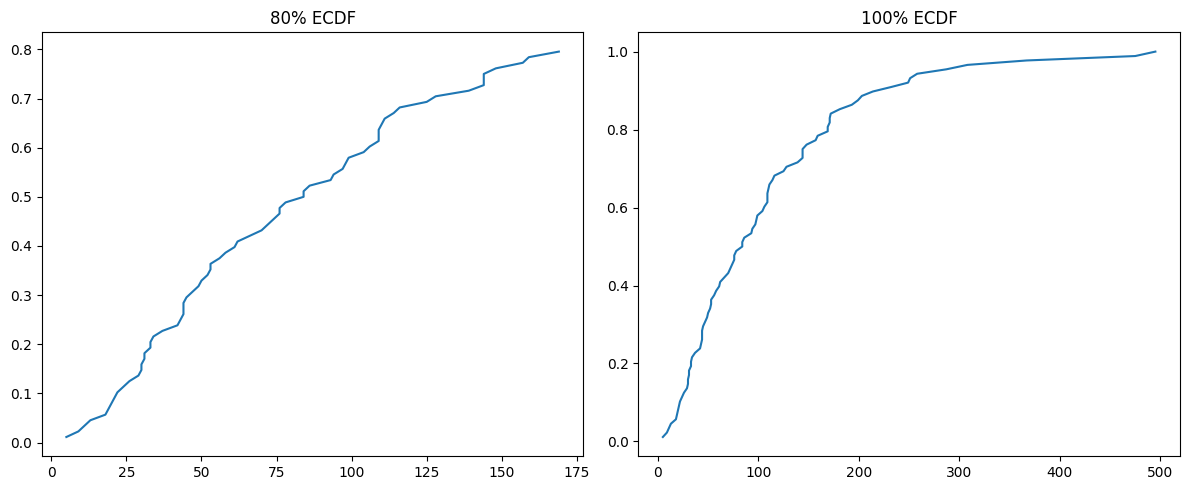

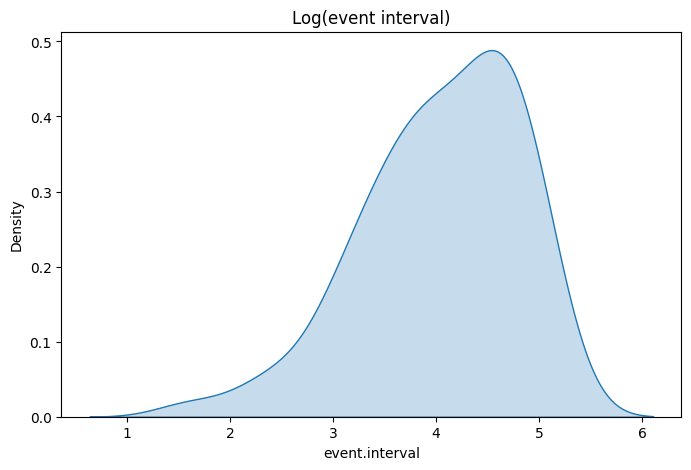

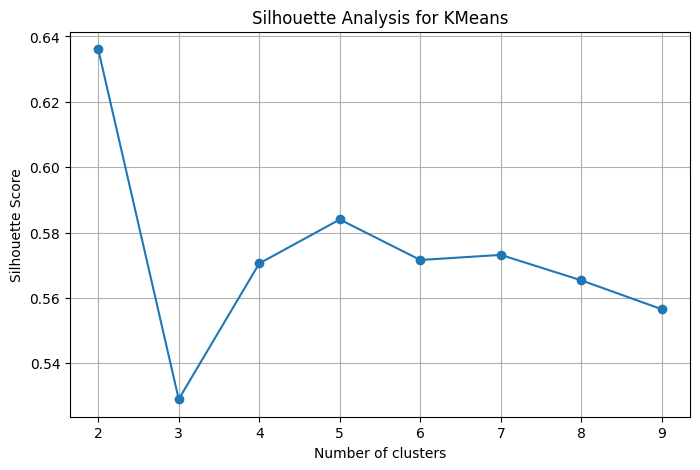

Optimal number of clusters for K-means: 2

Processing medA with DBSCAN clustering...


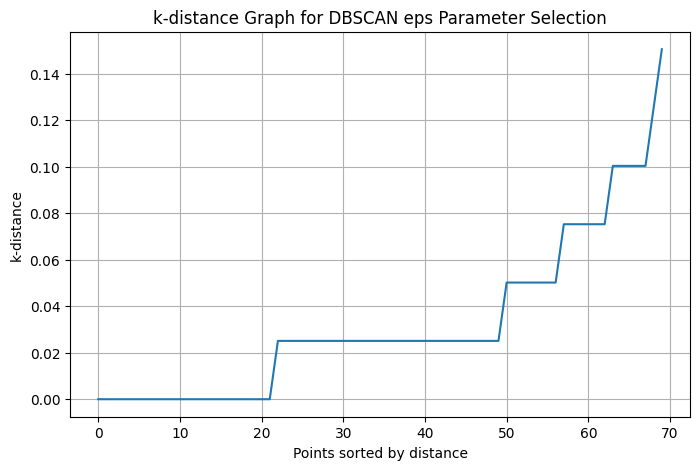

Optimal eps for DBSCAN: 0.5

Processing medB with K-means clustering...


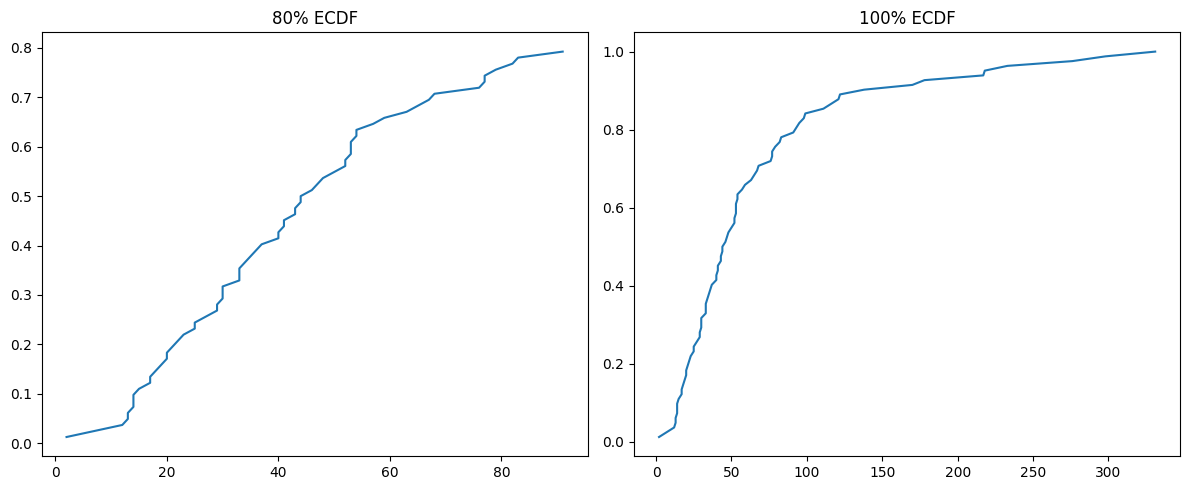

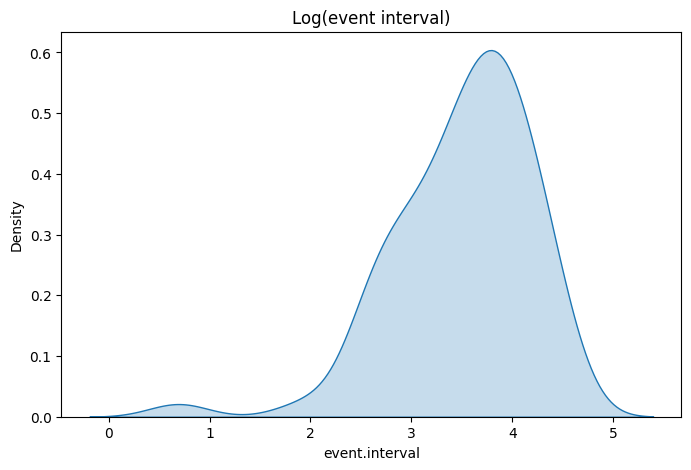

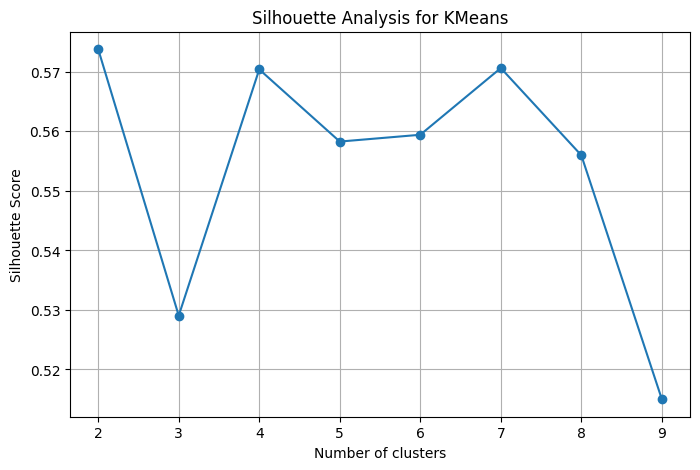

Optimal number of clusters for K-means: 2

Processing medB with DBSCAN clustering...


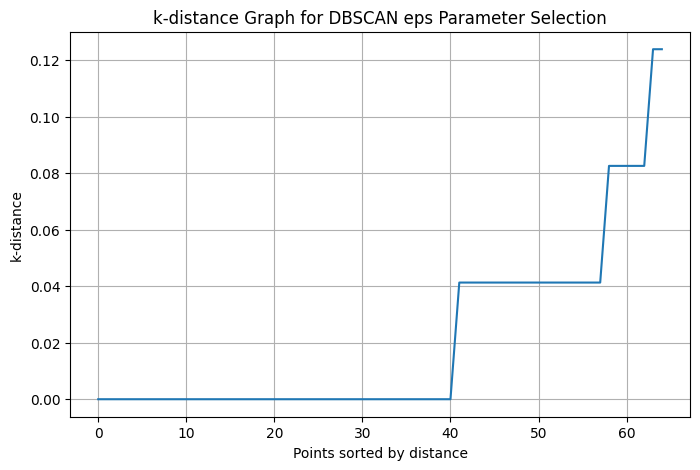

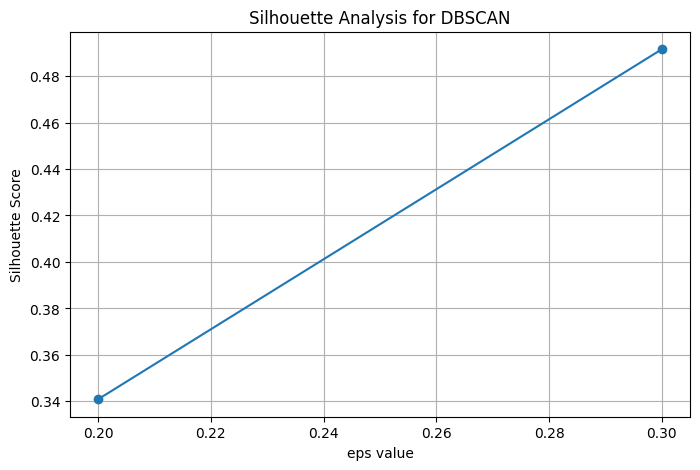

Optimal eps for DBSCAN: 0.30000000000000004


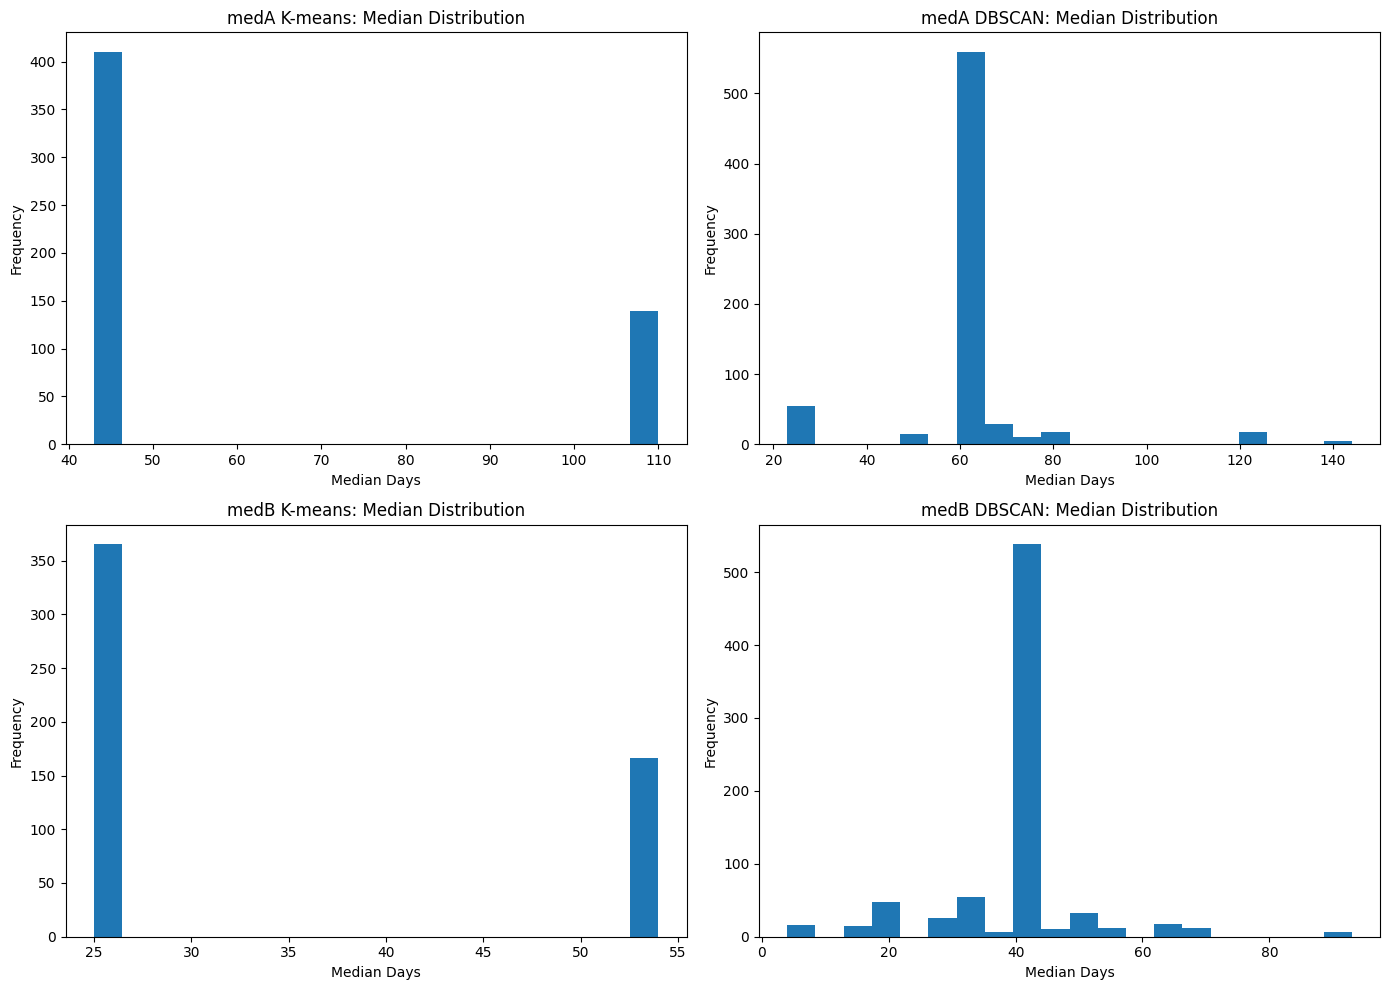


Visualizing assumption checks for medA with K-means:


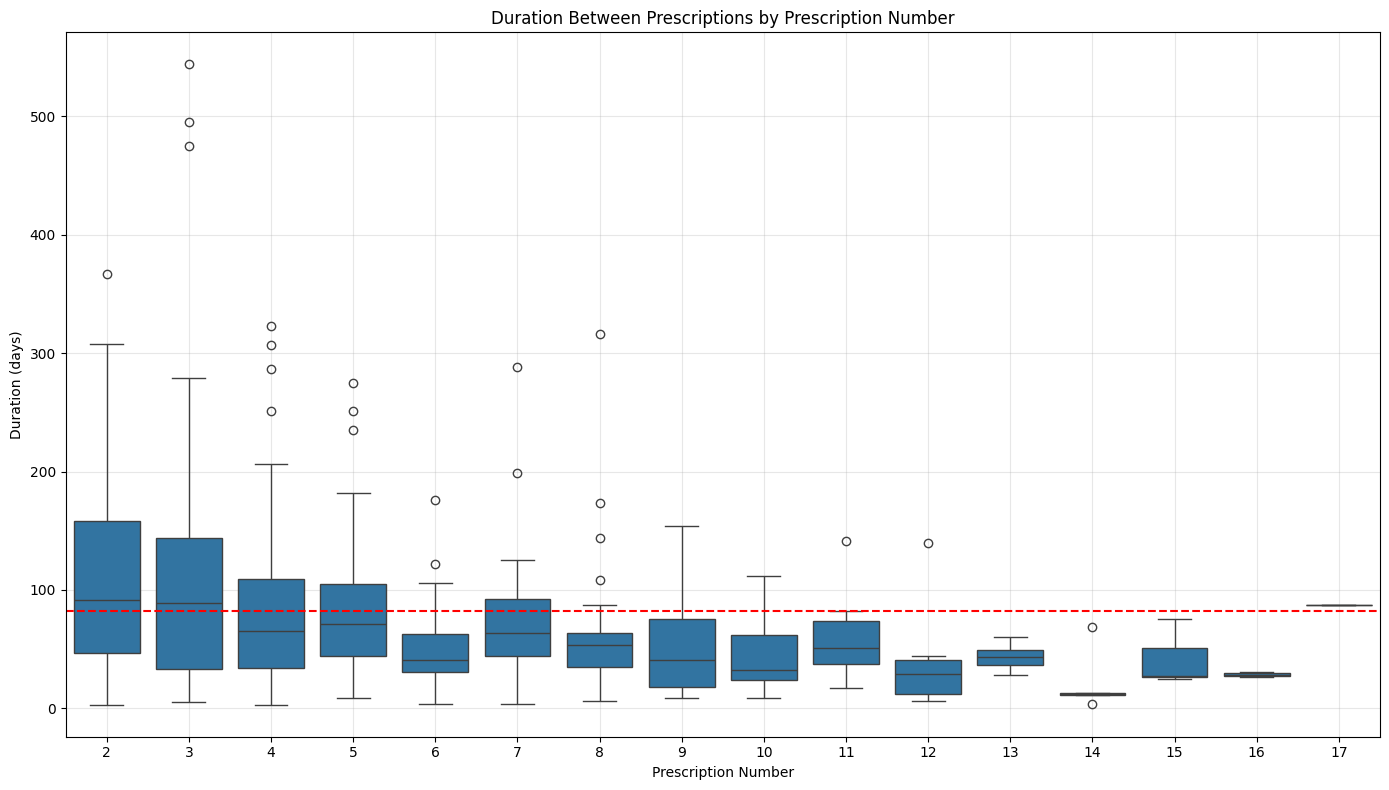

Visualizing assumption checks for medA with DBSCAN:


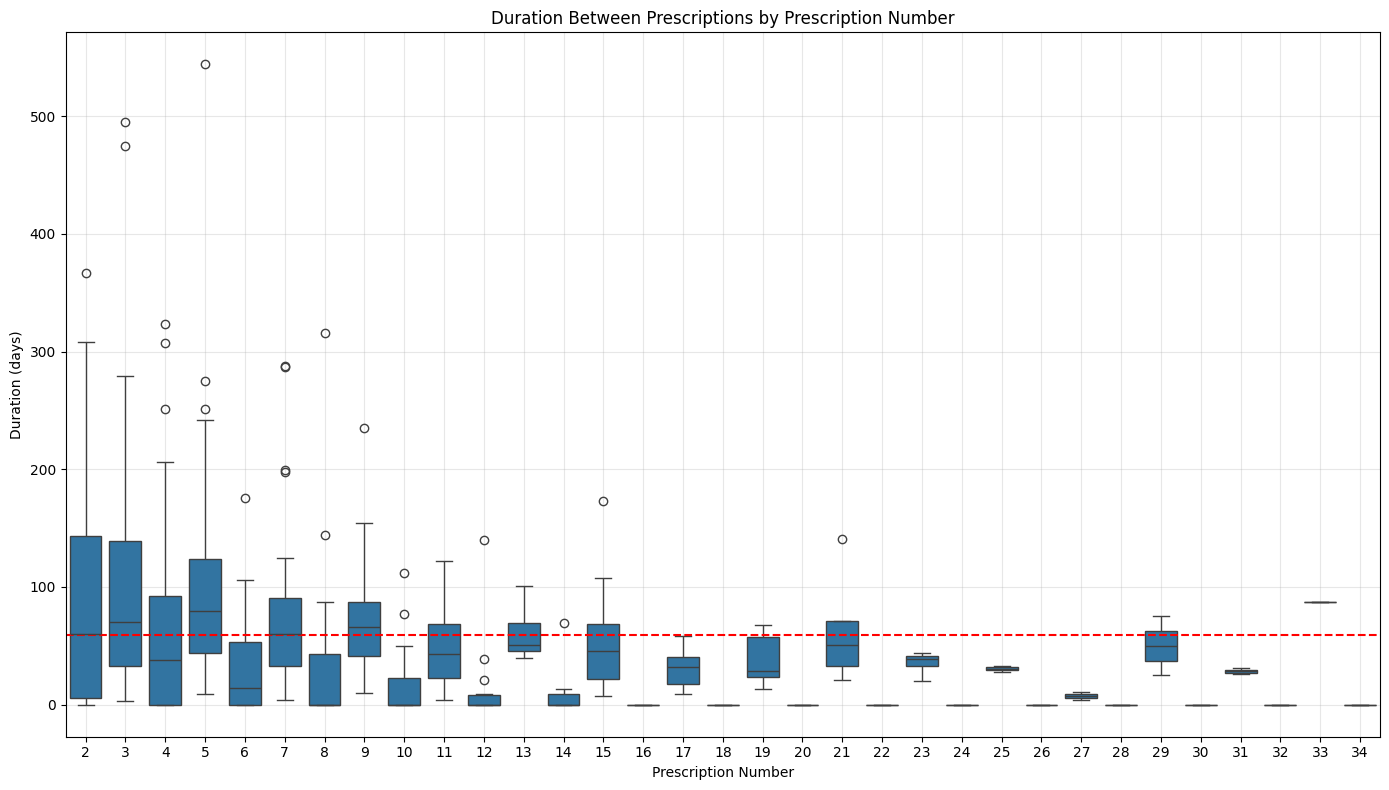

Visualizing assumption checks for medB with K-means:


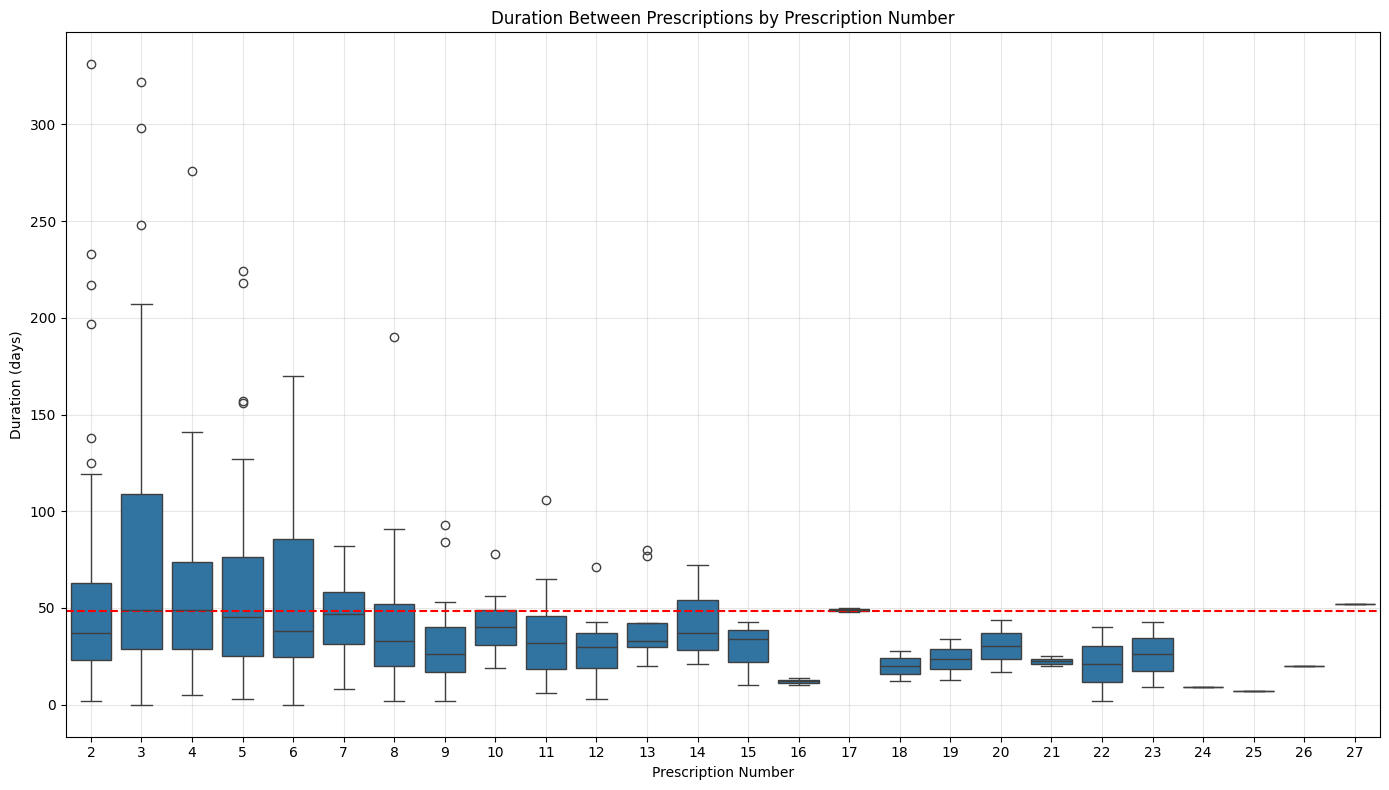

Visualizing assumption checks for medB with DBSCAN:


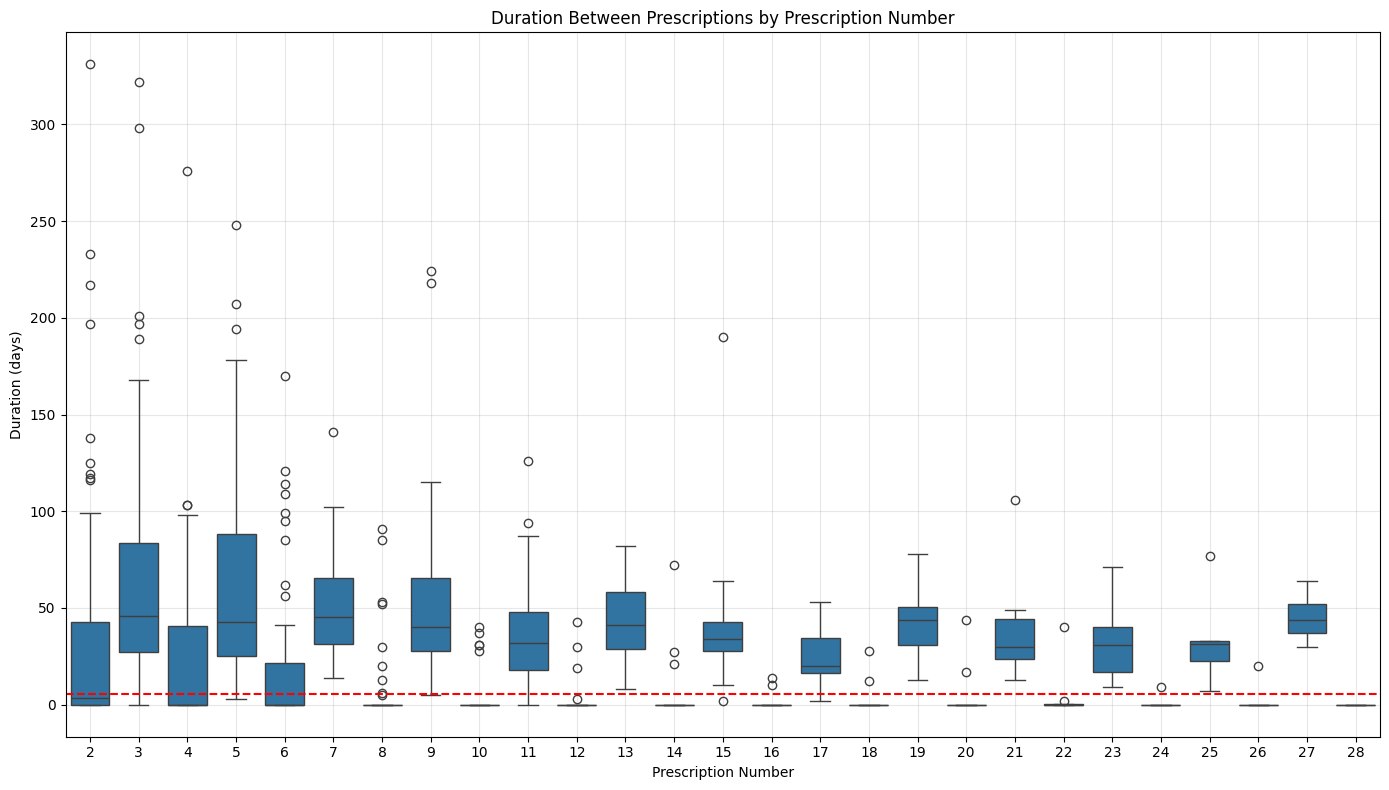


--- Summary Statistics ---

medA_kmeans Summary:
Number of clusters: 3
Median days: 43.0
Mean days: 59.96
Std deviation: 29.16

medA_dbscan Summary:
Number of clusters: 13
Median days: 64.0
Mean days: 63.80
Std deviation: 16.48

medB_kmeans Summary:
Number of clusters: 3
Median days: 25.0
Mean days: 34.07
Std deviation: 13.46

medB_dbscan Summary:
Number of clusters: 21
Median days: 40.5
Mean days: 39.00
Std deviation: 11.16


In [14]:
# Run the comparison
results = compare_clustering_methods()

# Summarize the results
print("\n--- Summary Statistics ---")
for name, df in results.items():
    print(f"\n{name} Summary:")
    print(f"Number of clusters: {df['Cluster'].nunique()}")
    print(f"Median days: {df['Median'].median()}")
    print(f"Mean days: {df['Median'].mean():.2f}")
    print(f"Std deviation: {df['Median'].std():.2f}")

# Analysis of SEE Clustering Results

## Key Statistics Comparison

### Medication A (medA)
#### K-means Results
- **Clusters**: 3
- **Median**: 43.0 days
- **Mean**: 59.96 days
- **Standard Deviation**: 29.16 days

#### DBSCAN Results
- **Clusters**: 13
- **Median**: 64.0 days
- **Mean**: 63.80 days
- **Standard Deviation**: 16.48 days

### Medication B (medB)
#### K-means Results
- **Clusters**: 3
- **Median**: 25.0 days
- **Mean**: 34.07 days
- **Standard Deviation**: 13.46 days

#### DBSCAN Results
- **Clusters**: 21
- **Median**: 40.5 days
- **Mean**: 39.00 days
- **Standard Deviation**: 11.16 days

## Algorithm Parameter Selection
- K-means optimal clusters: 2 (for both medications)
- DBSCAN optimal eps:
  - medA: 0.5
  - medB: 0.3

## Key Insights

### 1. Clustering Pattern Differences
- DBSCAN consistently identifies more granular clusters
  - medA: 13 vs 3 clusters
  - medB: 21 vs 3 clusters
- Suggests more complex underlying prescription patterns

### 2. Prescription Timing Patterns
#### Medication A
- Longer intervals between prescriptions
- DBSCAN shows more consistent patterns (lower std dev)
- K-means suggests higher variability in timing

#### Medication B
- Generally shorter prescription intervals
- More frequent dosing requirements
- More consistent patterns in both algorithms

### 3. Clinical Implications

#### Patient Behavior Patterns
- More diverse patterns in medB (21 DBSCAN clusters)
- More regular timing in medA prescriptions
- Lower standard deviations in DBSCAN suggest better pattern detection

#### Treatment Adherence
- medB requires more frequent prescriptions
- medA shows longer but more stable intervals
- DBSCAN reveals more nuanced adherence patterns

## Recommendations

### 1. Algorithm Selection
- **Use DBSCAN for**:
  - Detailed patient behavior analysis
  - Identifying unusual prescription patterns
  - Fine-grained adherence monitoring

- **Use K-means for**:
  - Quick pattern overview
  - Basic adherence categorization
  - Initial data exploration

### 2. Further Investigation Needed
1. Validate clinical significance of:
   - Longer intervals in DBSCAN results
   - Multiple cluster patterns in medB
2. Examine relationship between:
   - Cluster numbers and patient outcomes
   - Prescription patterns and treatment efficacy

### 3. Implementation Considerations
- Consider using both algorithms complementarily
- Monitor pattern changes over time
- Validate findings with clinical expertise